In [63]:
from stringprep import b1_set

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
with open('data/names.txt', 'r') as f:
    words = f.read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [65]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [66]:
block_size = 3 # context length

def build_dataset(words):
    # build the dataset
    X, Y = [], []
    for w in words:
        # print(w)
        # Лист болванка из 0 для дальнейшего заполнения
        context = [0] * block_size
        # print(context)
        for ch in w + '.':
            # Индекс символа в словаре
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # Убрали первый символ, добавили новый
            context = context[1:] + [ix] # crop and append
            # print(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [67]:
import random

# Начало случайного распределения зафиксировано, дальше все что будет генерироваться при перезапуске программы будет одинаковым. Если вызывать несколько раз внутри одной и той же программы, результаты будут разными
random.seed(42)

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [68]:
# Функция которая будет использоваться в последствии для сравнения градиентов расчитанных вручную с градиентами pytorch
def cmp(s, dt, t):
    '''


    :param s: Название того что сверяем
    :param dt: градиент расчитанный вручную
    :param t: Значения для которых pytorch вычислит градиент
    :return:
    '''
    # Проверка точного совпадения значений
    ex = torch.all(dt == t.grad).item()
    # Проверка приблизительного совпадения значений
    app = torch.allclose(dt, t.grad)
    # Максимальная существующая ошибка
    maxdiff = (dt - t.grad).abs().max().item()
    return print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [69]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [70]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

### forward pass, "chunkated" into smaller steps that are possible to backward one at a time

In [71]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

In [72]:
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

In [73]:
# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

In [74]:
# Non-linearity
h = torch.tanh(hpreact) # hidden layer

In [75]:
# Linear layer 2
logits = h @ W2 + b2 # output layer

cross entropy loss (same as F.cross_entropy(logits, Yb))

In [76]:
# Максимальный логит для каждого примера
logit_maxes = logits.max(1, keepdim=True).values
# Сделано для безопасности, чтобы не возводить в слишком большие степени
norm_logits = logits - logit_maxes

# Число e возводится в степень norm_logits
# То же самое что и counts = torch.exp(norm_logits)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)

# 1 / counts_sum
counts_sum_inv = counts_sum ** -1

# Softmax: преобразование логитов в вероятности
# значения ∈ (0, 1)
# сумма по классам = 1
# Тут закопан broadcasting, вектор counts_sum_inv был растянут по колонкам
probs = counts * counts_sum_inv

logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

In [77]:
# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3493, grad_fn=<NegBackward0>)

### 1) dlogprobs

loss = -logprobs[range(n), Yb].mean()

In [78]:
# Вероятности каждого из 27 возможных символов для каждого из 32 символов в батче
logprobs.shape

torch.Size([32, 27])

In [79]:
# Верные ответы
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [80]:
Yb.shape

torch.Size([32])

In [81]:
# Вероятность данная верным символам
logprobs[range(n), Yb]

tensor([-4.0103, -3.0944, -3.7406, -3.2428, -4.1888, -3.5452, -3.1165, -4.0411,
        -3.2254, -4.2812, -3.1920, -1.6542, -2.7785, -2.9414, -3.0518, -3.1880,
        -3.8239, -3.0806, -3.6025, -3.3742, -2.8925, -3.0833, -4.3268, -4.0731,
        -3.5120, -2.7640, -2.9755, -3.8537, -2.8191, -3.3755, -3.3038, -3.0248],
       grad_fn=<IndexBackward0>)

In [82]:
logprobs[range(n), Yb].shape

torch.Size([32])

Итого для каждого из 32 примеров в batch у нас есть вероятность для каждого из 27 потенциальных символов. Для верного ответа считается градиент ошибки, для остальных 26 нет

In [83]:
# dlogprobs = torch.zeros((logprobs.shape))
dlogprobs = torch.zeros_like(logprobs)
dlogprobs.shape

torch.Size([32, 27])

In [84]:
# dloss = - 1/n (n=32 в нашем случае)
dlogprobs[range(n), Yb] = -1.0 / n

In [85]:
# Сверка корректности расчета с torch
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### 2) dprobs

logprobs = probs.log()

В PyTorch torch.log(x) — это натуральный логарифм \ln(x).

![lnderin](images/d_ln.png)

In [86]:
logprobs.shape

torch.Size([32, 27])

In [87]:
probs.shape

torch.Size([32, 27])

In [88]:
dprobs = torch.zeros_like(logprobs)

In [89]:
# x = probs
# (1/ probs) - текущая производная
# dlogprobs - производная предыдущего слоя
dprobs = (1/ probs) * dlogprobs

In [90]:
# Сверка корректности расчета с torch
cmp('dprobs', dprobs, probs)

dprobs          | exact: True  | approximate: True  | maxdiff: 0.0


### 3) dcounts_sum_inv

Важное замечание, когда я считаю производную функции, я считаю производную строки где она была примененена, а не где она была вычислена, то есть не counts_sum_inv = counts_sum ** -1, а probs = counts * counts_sum_inv



probs = counts * counts_sum_inv

In [91]:
# Тут надо быть аккуратнее, имел место broadcasting
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [92]:
dprobs.shape

torch.Size([32, 27])

In [93]:
# Форма предыдущего слоя
dcounts_sum_inv = torch.zeros_like(counts)
dcounts_sum_inv

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

Ключевая идея (сразу)

.sum() нужен ТОЛЬКО тогда, когда один и тот же элемент входа
повлиял на НЕСКОЛЬКО элементов выхода.

Если влияние 1 → 1, суммировать нечего.

In [94]:
# x = counts
# dprobs = градиент предыдущего слоя probs

# counts * dprobs = x * производная предыдущего слоя, .sum(1, keepdim=True) - учет broadcasting
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

In [95]:
counts.shape, counts_sum_inv.shape, dcounts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 1]))

In [96]:
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


### 4) dcounts1

In [97]:
# Здесть почему-то не надо делать .sum()
dcounts = counts_sum_inv * dprobs
# cmp('dcounts', dcounts, counts)

# Пока что нет возможности проверить корректность counts тк оно влияет на результат не только в этом месте, а еще и в counts_sum = counts.sum(1, keepdims=True)

In [98]:
counts_sum_inv.shape, dprobs.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

### 5) dcounts_sum

counts_sum_inv = counts_sum ** -1

<img src="images/d_power.png" width="400">

In [99]:
# n = -1, x = counts_sum
# dcounts_sum_inv - градиент предыдущего слоя

dcounts_sum = (-1 * counts_sum **-2) * dcounts_sum_inv
cmp('dpow', dcounts_sum, counts_sum)

dpow            | exact: True  | approximate: True  | maxdiff: 0.0


### 6) Dcounts2

counts_sum = counts.sum(1, keepdims=True)


In [100]:
# a11 a12 a13  --> b1(a11 + a12 + a13)
# a21 a22 a23  --> b1(a31 + a22 + a23)
# s31 a32 a33  --> b1(a31 + a32 + a33)

In [101]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [102]:
# В операции .sum градиенты просто перетекают в след слой, поэтому я растянул их согласно размерностям
# torch.broadcast_to(dcounts, counts.shape)
# dcounts состоит из двух операций, первую мы посчитали выше, теперь прибавляю к ней результат текущей, и делаю проверку

dcounts += torch.ones_like(counts) * dcounts_sum
dcounts.shape

torch.Size([32, 27])

In [103]:
cmp('dcounts', dcounts, counts)

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


### 7) dnorm logits

counts = norm_logits.exp()


![image](images/d_exp.png)

In [104]:
# x - norm_logist
# prev_deriv = dcounts

# norm_logits.exp() = counts
dnorm_logits = counts * dcounts # dnorm = norm_logits.exp() * dcounts

In [105]:
torch.e, norm_logits.shape, (torch.e ** norm_logits).shape

(2.718281828459045, torch.Size([32, 27]), torch.Size([32, 27]))

In [106]:
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


### 8) dlogits

norm_logits = logits - logit_maxes

In [107]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

Опять broadcasting, надо следать учет на это

In [108]:
# Для dlogits это пока не финальная производная
dlogits = dnorm_logits.clone()
dlog_maxes = - dnorm_logits.clone().sum(1, keepdim=True)

In [109]:
cmp('dlogmaxes', dlog_maxes, logit_maxes)

dlogmaxes       | exact: True  | approximate: True  | maxdiff: 0.0


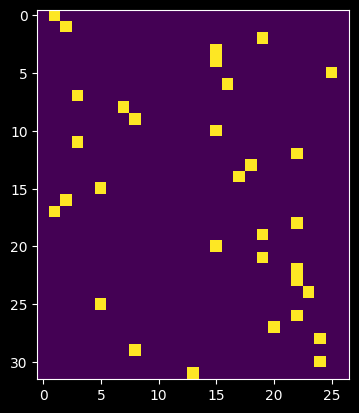

In [110]:
# Найти индексы максимальных значений и оставить их
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

# Вторая часть градиента от logits, передать через эти узлы градиент
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlog_maxes

In [111]:
cmp('dlogits', dlogits, logits)

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


# 9) logits = h @ W2 + b2

logits = h @ W2 + b2

Производная матричного умножения может быть выведена вручную, прото это довольно долгий процесс. В конечном счете она вся состоит из простых умножений и сложений.

![dmatmul1](images/dmatmul1.png)

![dmatmul2](images/dmatmul2.png)

![dmatmul3](images/dmatmul3.png)

In [112]:
dlogits.shape, h.shape, h.T.shape, W2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 32]),
 torch.Size([64, 27]))

In [113]:
dw2 = h.T @ dlogits

In [114]:
cmp('dw2', dw2, W2)

dw2             | exact: True  | approximate: True  | maxdiff: 0.0


In [115]:
dh = dlogits @ W2.T

In [116]:
cmp('dw2', dh, h)

dw2             | exact: True  | approximate: True  | maxdiff: 0.0


In [117]:
b2.shape

torch.Size([27])

In [118]:
db2 = dlogits.sum(0, keepdim=True)

In [119]:
cmp('db2', db2, b2)

db2             | exact: True  | approximate: True  | maxdiff: 0.0


### 10) dhpreact

h = torch.tanh(hpreact)

![tanh](images/d_tanh.png)

In [120]:
# a = h
# dh - пред градиент

dhpreact = dh * (1 - h ** 2)

In [121]:
cmp('dhpreact', dhpreact, hpreact)

dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0


### 11) hpreact = bngain * bnraw + bnbias

In [122]:
bngain.shape, bnbias.shape, bnraw.shape, hpreact.shape

(torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [123]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

In [124]:
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)

dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0


### Оставшиеся градиенты

In [126]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]